# 3rd Model: Deepgraph CNN: Stock Price Prediction using DeepGraphCNN Neural Networks. It includes GCN layers and CNN layers. I have added an MLP at the last layer to predict stock prices.

# Input graphs were created for Pearson, Spearman, and Kendal Tau correlations/coefficients from historical stock prices. Also, another graph is created based on financial news articles.

# For the sake of making execution easier (and at once), I have kept multiple approaches (Pearson, Spearman, and Kendal Tau, News Based) in the same file. One big code file can be difficult to handle; is done just for making execution easier.

# Because I initially tried separately and brought the code together, some code might be a bit redundant/repeating. I may have done some cleaning.

# An use case of DeepGraphCNN for Node Classification
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


# Import Libraries

In [1]:
# import libraries
import os
import pandas as pd
import math

In [2]:
# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN

In [3]:
# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras

In [4]:
# If we want to drop NAN column or row wise for stock price data
# I did not need to use this options that much
drop_cols_with_na = 1
drop_rows_with_na = 1

# Dataset: Using 30 companies from the Fortune 500 companies (the paper used these stocks)

In [5]:
df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()

,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03 00:00:00,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04 00:00:00,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05 00:00:00,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06 00:00:00,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09 00:00:00,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001


In [6]:
# You can see ANTM stock price data is empty

# Cure data such as replace missing/null values, use correct data type, sort by date (not really required)

In [7]:
# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted when I generated data
# df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()

,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001


In [8]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit

# check if any value is null    
df_s_transpose.isnull().values.any()

# check if any column (axis=1) is null
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    

An exception occurred. Operation ignored


,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2019-12-23,71.000000,85.599998,89.650002,NaN,337.549988,35.169998,51.130001,293.309998,74.379997,...,53.033333,112.669998,29.509064,295.089996,179.419998,61.400002,58.570000,53.810001,119.029999,70.290001
749,2019-12-24,71.067497,85.419998,89.460503,NaN,333.000000,35.220001,51.290001,294.230011,74.510002,...,52.993332,113.199997,29.425982,294.540009,179.889999,61.279999,58.349998,53.820000,119.510002,70.019997
750,2019-12-26,72.477501,85.050003,93.438499,NaN,329.920013,35.520000,51.169998,295.730011,74.480003,...,53.006668,112.059998,29.577040,295.649994,180.809998,61.290001,58.900002,54.150002,119.519997,70.129997
751,2019-12-27,72.449997,84.910004,93.489998,NaN,330.140015,35.349998,51.500000,294.109985,74.400002,...,52.939999,110.599998,29.637463,295.970001,181.410004,61.529999,59.020000,53.919998,119.589996,69.889999


In [9]:
df_s_transpose

,Date,AAPL,ABC,AMZN,ANTM,BA,BAC,CAH,COST,CVS,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03,29.037500,82.610001,37.683498,NaN,156.970001,22.530001,74.480003,159.729996,80.349998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04,29.004999,84.660004,37.859001,NaN,158.619995,22.950001,75.629997,159.759995,79.750000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05,29.152500,83.680000,39.022499,NaN,158.710007,22.680000,74.500000,162.910004,81.419998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06,29.477501,84.800003,39.799500,NaN,159.100006,22.680000,75.330002,162.830002,82.199997,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09,29.747499,85.480003,39.846001,NaN,158.320007,22.549999,74.760002,160.970001,81.699997,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2019-12-23,71.000000,85.599998,89.650002,NaN,337.549988,35.169998,51.130001,293.309998,74.379997,...,53.033333,112.669998,29.509064,295.089996,179.419998,61.400002,58.570000,53.810001,119.029999,70.290001
749,2019-12-24,71.067497,85.419998,89.460503,NaN,333.000000,35.220001,51.290001,294.230011,74.510002,...,52.993332,113.199997,29.425982,294.540009,179.889999,61.279999,58.349998,53.820000,119.510002,70.019997
750,2019-12-26,72.477501,85.050003,93.438499,NaN,329.920013,35.520000,51.169998,295.730011,74.480003,...,53.006668,112.059998,29.577040,295.649994,180.809998,61.290001,58.900002,54.150002,119.519997,70.129997
751,2019-12-27,72.449997,84.910004,93.489998,NaN,330.140015,35.349998,51.500000,294.109985,74.400002,...,52.939999,110.599998,29.637463,295.970001,181.410004,61.529999,59.020000,53.919998,119.589996,69.889999


In [10]:
# df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
print(df_s_transpose.shape)
df_s_transpose.head() 

(753, 29)


,Date,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
0,2017-01-03,29.037500,82.610001,37.683498,156.970001,22.530001,74.480003,159.729996,80.349998,117.849998,...,43.546665,86.790001,32.492447,161.449997,102.519997,54.580002,82.959999,56.000000,68.660004,90.889999
1,2017-01-04,29.004999,84.660004,37.859001,158.619995,22.950001,75.629997,159.759995,79.750000,117.820000,...,44.146667,87.260002,32.303623,161.910004,103.139999,54.520000,82.980003,56.049999,69.059998,89.889999
2,2017-01-05,29.152500,83.680000,39.022499,158.710007,22.680000,74.500000,162.910004,81.419998,117.309998,...,43.426666,86.739998,32.212990,162.179993,102.129997,54.639999,83.029999,55.180000,69.209999,88.550003
3,2017-01-06,29.477501,84.800003,39.799500,159.100006,22.680000,75.330002,162.830002,82.199997,116.839996,...,43.919998,85.400002,31.208460,162.410004,103.190002,53.259998,83.099998,55.040001,68.260002,88.500000
4,2017-01-09,29.747499,85.480003,39.846001,158.320007,22.549999,74.760002,160.970001,81.699997,115.839996,...,43.380001,84.019997,30.815710,161.949997,102.419998,52.680000,82.550003,54.240002,68.709999,87.040001


In [11]:
# further check and verify
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]

,Date,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM


In [12]:
# making the date column as the index column for the dataset
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')

# Pearson Correlation Coefficient

In [13]:
df_s_transpose_pearson = df_s_transpose.corr(method = 'pearson', numeric_only = True)
df_s_transpose_pearson

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,1.000000,-0.036748,0.786106,0.692570,0.763609,-0.666770,0.863643,-0.342350,0.459125,-0.593845,...,0.427859,0.745233,-0.262982,0.760652,0.798973,0.676181,-0.658245,-0.197965,0.827489,-0.505612
ABC,-0.036748,1.000000,-0.127768,-0.126217,0.163579,0.466160,-0.130971,0.427752,0.029482,0.302385,...,0.154842,0.097029,0.358636,-0.055076,-0.178882,-0.252366,0.300615,0.574354,-0.079702,0.250188
AMZN,0.786106,-0.127768,1.000000,0.909833,0.739494,-0.876488,0.826927,-0.673998,0.601387,-0.721688,...,0.071989,0.690894,-0.677553,0.886126,0.929052,0.708967,-0.763988,-0.409286,0.765665,-0.457154
BA,0.692570,-0.126217,0.909833,1.000000,0.782307,-0.828416,0.699197,-0.661338,0.662725,-0.672301,...,0.103744,0.688694,-0.708575,0.886833,0.873865,0.653679,-0.707509,-0.328412,0.765026,-0.413556
BAC,0.763609,0.163579,0.739494,0.782307,1.000000,-0.523495,0.613895,-0.389465,0.670267,-0.347324,...,0.484901,0.804676,-0.315603,0.770331,0.727145,0.485319,-0.604695,0.127918,0.705303,-0.297798
CAH,-0.666770,0.466160,-0.876488,-0.828416,-0.523495,1.000000,-0.766108,0.746348,-0.539610,0.709460,...,0.059840,-0.558826,0.741128,-0.795163,-0.851249,-0.711528,0.791882,0.596125,-0.739558,0.523205
COST,0.863643,-0.130971,0.826927,0.699197,0.613895,-0.766108,1.000000,-0.553276,0.444068,-0.712750,...,0.317508,0.541579,-0.297706,0.695051,0.902083,0.864420,-0.766485,-0.473844,0.893336,-0.648205
CVS,-0.342350,0.427752,-0.673998,-0.661338,-0.389465,0.746348,-0.553276,1.000000,-0.440430,0.464550,...,0.017925,-0.225111,0.586122,-0.439705,-0.686060,-0.463266,0.850140,0.643467,-0.529032,0.449050
CVX,0.459125,0.029482,0.601387,0.662725,0.670267,-0.539610,0.444068,-0.440430,1.000000,-0.087233,...,0.293140,0.717509,-0.388580,0.594834,0.602565,0.419555,-0.535137,0.040413,0.482086,0.101968
F,-0.593845,0.302385,-0.721688,-0.672301,-0.347324,0.709460,-0.712750,0.464550,-0.087233,1.000000,...,0.115762,-0.306461,0.563575,-0.678168,-0.727356,-0.726151,0.467808,0.607512,-0.640430,0.652238


# Pearson Correlation Coefficient based Adjacency Graph Matrix

In [14]:
df_s_transpose_pearson[df_s_transpose_pearson >= 0.5] = 1
df_s_transpose_pearson[df_s_transpose_pearson < 0.5] = 0
df_s_transpose_pearson

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ABC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AMZN,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BA,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BAC,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
CAH,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
COST,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
CVS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
CVX,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [15]:
# make the diagonal element to be zero. No self loop/edge
import numpy as np
np.fill_diagonal(df_s_transpose_pearson.values, 0)
df_s_transpose_pearson

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
ABC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
AMZN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BA,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
BAC,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
CAH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
COST,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
CVS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
CVX,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [16]:
# STOP

Create and visualize the Graphs

In [17]:
import networkx as nx
Graph_pearson = nx.Graph(df_s_transpose_pearson)

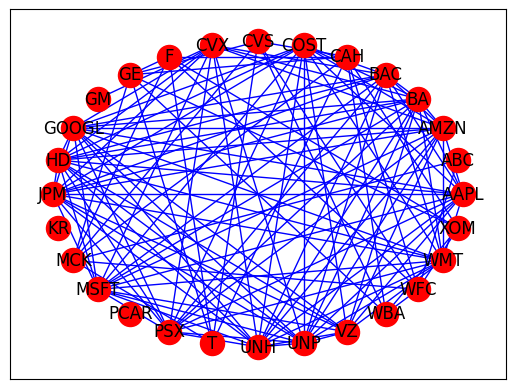

In [18]:
nx.draw_networkx(Graph_pearson, pos = nx.circular_layout( Graph_pearson ), node_color = 'r', edge_color = 'b')

# Experiment, we will divide the data into train, test, and validation graphs

In [19]:
df_s_transpose.corr(method = 'pearson', numeric_only = True)
#df_s_transpose[[{1,2,3}]]
#df_s_transpose.iloc[:, 0:10]


,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,...,PCAR,PSX,T,UNH,UNP,VZ,WBA,WFC,WMT,XOM
AAPL,1.000000,-0.036748,0.786106,0.692570,0.763609,-0.666770,0.863643,-0.342350,0.459125,-0.593845,...,0.427859,0.745233,-0.262982,0.760652,0.798973,0.676181,-0.658245,-0.197965,0.827489,-0.505612
ABC,-0.036748,1.000000,-0.127768,-0.126217,0.163579,0.466160,-0.130971,0.427752,0.029482,0.302385,...,0.154842,0.097029,0.358636,-0.055076,-0.178882,-0.252366,0.300615,0.574354,-0.079702,0.250188
AMZN,0.786106,-0.127768,1.000000,0.909833,0.739494,-0.876488,0.826927,-0.673998,0.601387,-0.721688,...,0.071989,0.690894,-0.677553,0.886126,0.929052,0.708967,-0.763988,-0.409286,0.765665,-0.457154
BA,0.692570,-0.126217,0.909833,1.000000,0.782307,-0.828416,0.699197,-0.661338,0.662725,-0.672301,...,0.103744,0.688694,-0.708575,0.886833,0.873865,0.653679,-0.707509,-0.328412,0.765026,-0.413556
BAC,0.763609,0.163579,0.739494,0.782307,1.000000,-0.523495,0.613895,-0.389465,0.670267,-0.347324,...,0.484901,0.804676,-0.315603,0.770331,0.727145,0.485319,-0.604695,0.127918,0.705303,-0.297798
CAH,-0.666770,0.466160,-0.876488,-0.828416,-0.523495,1.000000,-0.766108,0.746348,-0.539610,0.709460,...,0.059840,-0.558826,0.741128,-0.795163,-0.851249,-0.711528,0.791882,0.596125,-0.739558,0.523205
COST,0.863643,-0.130971,0.826927,0.699197,0.613895,-0.766108,1.000000,-0.553276,0.444068,-0.712750,...,0.317508,0.541579,-0.297706,0.695051,0.902083,0.864420,-0.766485,-0.473844,0.893336,-0.648205
CVS,-0.342350,0.427752,-0.673998,-0.661338,-0.389465,0.746348,-0.553276,1.000000,-0.440430,0.464550,...,0.017925,-0.225111,0.586122,-0.439705,-0.686060,-0.463266,0.850140,0.643467,-0.529032,0.449050
CVX,0.459125,0.029482,0.601387,0.662725,0.670267,-0.539610,0.444068,-0.440430,1.000000,-0.087233,...,0.293140,0.717509,-0.388580,0.594834,0.602565,0.419555,-0.535137,0.040413,0.482086,0.101968
F,-0.593845,0.302385,-0.721688,-0.672301,-0.347324,0.709460,-0.712750,0.464550,-0.087233,1.000000,...,0.115762,-0.306461,0.563575,-0.678168,-0.727356,-0.726151,0.467808,0.607512,-0.640430,0.652238


In [20]:
# Train Graph

In [21]:
df_s_pearson_train = df_s_transpose.iloc[:, 0:15]
df_s_transpose_pearson_train = df_s_pearson_train.corr(method = 'pearson', numeric_only = True)
np.fill_diagonal(df_s_transpose_pearson_train.values, 0)

df_s_transpose_pearson_train[df_s_transpose_pearson_train >= 0.5] = 1
df_s_transpose_pearson_train[df_s_transpose_pearson_train < 0.5] = 0
df_s_transpose_pearson_train

df_s_transpose_pearson_train

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,GE,GM,GOOGL,HD
AAPL,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
ABC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AMZN,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
BA,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
BAC,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
CAH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
COST,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
CVS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
CVX,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
F,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Test Graph

In [22]:
df_s_pearson_test = df_s_transpose.iloc[:, 15:23]
df_s_transpose_pearson_test = df_s_pearson_test.corr(method = 'pearson', numeric_only = True)
np.fill_diagonal(df_s_transpose_pearson_test.values, 0)

df_s_transpose_pearson_train[df_s_transpose_pearson_test >= 0.5] = 1
df_s_transpose_pearson_train[df_s_transpose_pearson_test < 0.5] = 0
df_s_transpose_pearson_test

,JPM,KR,MCK,MSFT,PCAR,PSX,T,UNH
JPM,0.000000,-0.099604,-0.219086,0.845101,0.480762,0.791179,-0.306340,0.813623
KR,-0.099604,0.000000,-0.124950,-0.199669,-0.165326,-0.000130,0.155794,-0.045956
MCK,-0.219086,-0.124950,0.000000,-0.447254,0.307479,-0.160706,0.673269,-0.480768
MSFT,0.845101,-0.199669,-0.447254,0.000000,0.322893,0.591259,-0.432385,0.794765
PCAR,0.480762,-0.165326,0.307479,0.322893,0.000000,0.250929,0.412006,0.088494
PSX,0.791179,-0.000130,-0.160706,0.591259,0.250929,0.000000,-0.348642,0.736617
T,-0.306340,0.155794,0.673269,-0.432385,0.412006,-0.348642,0.000000,-0.703425
UNH,0.813623,-0.045956,-0.480768,0.794765,0.088494,0.736617,-0.703425,0.000000


# Validation Graph

In [23]:
df_s_pearson_validation = df_s_transpose.iloc[:, 23:]
df_s_transpose_pearson_validation = df_s_pearson_validation.corr(method = 'pearson', numeric_only = True)
np.fill_diagonal(df_s_transpose_pearson_validation.values, 0)
df_s_transpose_pearson_validation

df_s_transpose_pearson_validation[df_s_transpose_pearson_validation >= 0.5] = 1
df_s_transpose_pearson_validation[df_s_transpose_pearson_validation < 0.5] = 0
df_s_transpose_pearson_validation

,UNP,VZ,WBA,WFC,WMT,XOM
UNP,0.0,1.0,0.0,0.0,1.0,0.0
VZ,1.0,0.0,0.0,0.0,1.0,0.0
WBA,0.0,0.0,0.0,1.0,0.0,1.0
WFC,0.0,0.0,1.0,0.0,0.0,1.0
WMT,1.0,1.0,0.0,0.0,0.0,0.0
XOM,0.0,0.0,1.0,1.0,0.0,0.0


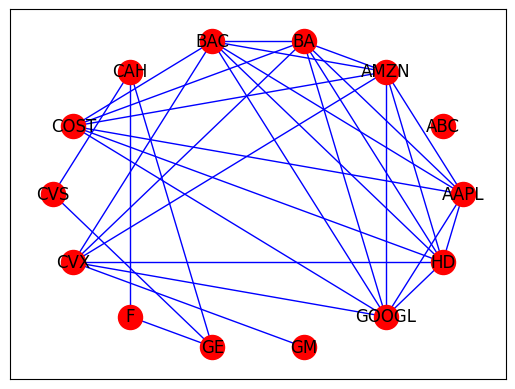

In [24]:
graph_pearson_train = nx.Graph(df_s_transpose_pearson_train)
graph_pearson_test = nx.Graph(df_s_transpose_pearson_test)
graph_pearson_validation = nx.Graph(df_s_transpose_pearson_validation)


nx.draw_networkx(graph_pearson_train, pos = nx.circular_layout( graph_pearson_train ), node_color = 'r', edge_color = 'b')


In [25]:
df_s_pearson_train.corr(numeric_only = True)

,AAPL,ABC,AMZN,BA,BAC,CAH,COST,CVS,CVX,F,GE,GM,GOOGL,HD
AAPL,1.000000,-0.036748,0.786106,0.692570,0.763609,-0.666770,0.863643,-0.342350,0.459125,-0.593845,-0.688955,-0.043523,0.888000,0.877335
ABC,-0.036748,1.000000,-0.127768,-0.126217,0.163579,0.466160,-0.130971,0.427752,0.029482,0.302385,0.212265,0.032142,-0.064546,-0.012956
AMZN,0.786106,-0.127768,1.000000,0.909833,0.739494,-0.876488,0.826927,-0.673998,0.601387,-0.721688,-0.917546,-0.007530,0.876585,0.860812
BA,0.692570,-0.126217,0.909833,1.000000,0.782307,-0.828416,0.699197,-0.661338,0.662725,-0.672301,-0.939535,0.197818,0.839987,0.816428
BAC,0.763609,0.163579,0.739494,0.782307,1.000000,-0.523495,0.613895,-0.389465,0.670267,-0.347324,-0.696132,0.323353,0.841836,0.792398
CAH,-0.666770,0.466160,-0.876488,-0.828416,-0.523495,1.000000,-0.766108,0.746348,-0.539610,0.709460,0.900806,-0.058398,-0.757748,-0.762504
COST,0.863643,-0.130971,0.826927,0.699197,0.613895,-0.766108,1.000000,-0.553276,0.444068,-0.712750,-0.757072,-0.104827,0.816834,0.899330
CVS,-0.342350,0.427752,-0.673998,-0.661338,-0.389465,0.746348,-0.553276,1.000000,-0.440430,0.464550,0.683847,-0.147932,-0.518179,-0.545253
CVX,0.459125,0.029482,0.601387,0.662725,0.670267,-0.539610,0.444068,-0.440430,1.000000,-0.087233,-0.556104,0.512428,0.588503,0.619018
F,-0.593845,0.302385,-0.721688,-0.672301,-0.347324,0.709460,-0.712750,0.464550,-0.087233,1.000000,0.751037,0.409949,-0.628489,-0.576284


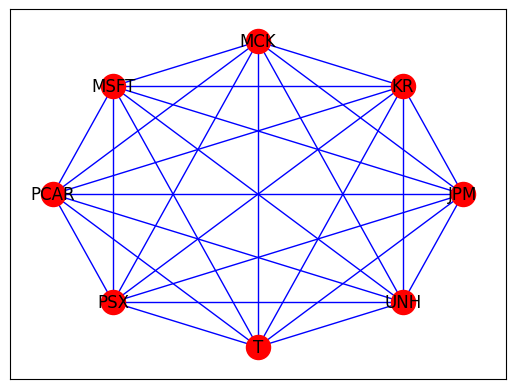

In [26]:
nx.draw_networkx(graph_pearson_test, pos = nx.circular_layout( graph_pearson_test ), node_color = 'r', edge_color = 'b')

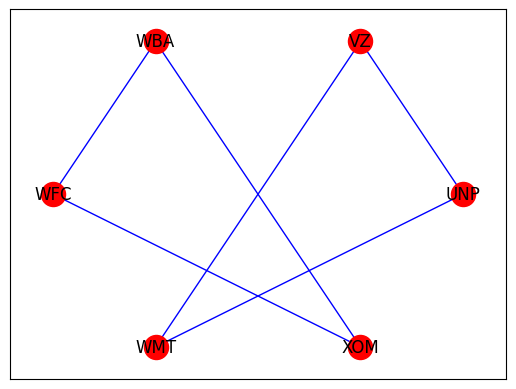

In [27]:
nx.draw_networkx(graph_pearson_validation, pos = nx.circular_layout( graph_pearson_validation ), node_color = 'r', edge_color = 'b')

# Create GCN layer. Pearson

# Find all stocks = nodes

In [28]:
# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_pearson.index.to_list()
all_stock_nodes[:5]

['AAPL', 'ABC', 'AMZN', 'BA', 'BAC']

# Find all edges between nodes

This may need adjustment to reflect train, test, validation graphs

In [29]:
source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_pearson[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)

# edge feature is not required except for news based graph
source, target, edge_feature            

(['AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'AAPL',
  'ABC',
  'ABC',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'AMZN',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BA',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'BAC',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'CAH',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'COST',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVS',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'CVX',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GE',
  'GM',
  'GOOGL',
  'GOOGL',


# Find all edges in Train, Test, and Validation Graphs

In [30]:
trainSource = [];
trainTarget = [];
trainEdge_feature = [];
trainNodeList = df_s_transpose_pearson_train.index.to_list();

testSource = [];
testTarget = [];
testEdge_feature = [];
testNodeList = df_s_transpose_pearson_test.index.to_list();


validationSource = [];
validationTarget = [];
validationEdge_feature = [];
validationNodeList = df_s_transpose_pearson_validation.index.to_list();

for aStock in trainNodeList:
    for anotherStock in trainNodeList:        
        if df_s_transpose_pearson_train[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            trainSource.append(aStock)
            trainTarget.append(anotherStock)
            trainEdge_feature.append(1)
                
                
for aStock in testNodeList:
    for anotherStock in testNodeList:
        if df_s_transpose_pearson_test[aStock][anotherStock] > 0:
            #print(df_s_transpose_pearson[aStock][anotherStock])
            testSource.append(aStock)
            testTarget.append(anotherStock)
            testEdge_feature.append(1)

for aStock in validationNodeList:
    for anotherStock in validationNodeList:
        if df_s_transpose_pearson_validation[aStock][anotherStock] > 0:
            # print(df_s_transpose_pearson[aStock][anotherStock])
            validationSource.append(aStock)
            validationTarget.append(anotherStock)
            validationEdge_feature.append(1)
                        
# edge feature is not required except for news based graph
trainSource, trainTarget, trainEdge_feature
testSource, testTarget, testEdge_feature
validationSource, validationTarget, validationEdge_feature

(['UNP',
  'UNP',
  'VZ',
  'VZ',
  'WBA',
  'WBA',
  'WFC',
  'WFC',
  'WMT',
  'WMT',
  'XOM',
  'XOM'],
 ['VZ',
  'WMT',
  'UNP',
  'WMT',
  'WFC',
  'XOM',
  'WBA',
  'XOM',
  'UNP',
  'VZ',
  'WBA',
  'WFC'],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Create variables to create stellar graph
# Edges

In [31]:
# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges = pd.DataFrame(
    {"source": source, "target": target}
)

pearson_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
pearson_edges_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget}
)

pearson_edges_data_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget, "edge_feature": trainEdge_feature}
)

pearson_edges_test = pd.DataFrame(
    {"source": testSource, "target": testTarget}
)

pearson_edges_data_test = pd.DataFrame(
    {"source": testSource, "target": testTarget, "edge_feature": testEdge_feature}
)


pearson_edges_validation = pd.DataFrame(
    {"source": validationSource, "target": validationTarget}
)


pearson_edges_train[:10]

,source,target
0,AAPL,AMZN
1,AAPL,BA
2,AAPL,BAC
3,AAPL,COST
4,AAPL,GOOGL
5,AAPL,HD
6,AMZN,AAPL
7,AMZN,BA
8,AMZN,BAC
9,AMZN,COST


# Have the time series data as part of the nodes

# Structure the Feature Matrix so that it can be passed to the GCN

In [32]:
df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].shape, df_s_transpose_feature['AAPL'].values

((753,),
 array([29.03750038, 29.00499916, 29.15250015, 29.47750092, 29.74749947,
        29.77750015, 29.9375    , 29.8125    , 29.76000023, 30.        ,
        29.99749947, 29.94499969, 30.        , 30.02000046, 29.99250031,
        30.46999931, 30.48500061, 30.48749924, 30.40749931, 30.33749962,
        32.1875    , 32.13249969, 32.27000046, 32.57249832, 32.88249969,
        33.00999832, 33.10499954, 33.02999878, 33.32249832, 33.75500107,
        33.87749863, 33.83750153, 33.93000031, 34.17499924, 34.27750015,
        34.13249969, 34.16500092, 34.23249817, 34.24750137, 34.94749832,
        34.74000168, 34.94499969, 34.83499908, 34.88000107, 34.75      ,
        34.66999817, 34.78499985, 34.79999924, 34.74750137, 35.11500168,
        35.17250061, 34.99750137, 35.36500168, 34.95999908, 35.35499954,
        35.22999954, 35.15999985, 35.22000122, 35.95000076, 36.02999878,
        35.98249817, 35.91500092, 35.92499924, 36.19250107, 36.00500107,
        35.91500092, 35.83499908, 35.79249

In [33]:
len(all_stock_nodes)

28

In [34]:
# bring/assign data to nodes
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    

[array([29.03750038, 29.00499916, 29.15250015, 29.47750092, 29.74749947,
        29.77750015, 29.9375    , 29.8125    , 29.76000023, 30.        ,
        29.99749947, 29.94499969, 30.        , 30.02000046, 29.99250031,
        30.46999931, 30.48500061, 30.48749924, 30.40749931, 30.33749962,
        32.1875    , 32.13249969, 32.27000046, 32.57249832, 32.88249969,
        33.00999832, 33.10499954, 33.02999878, 33.32249832, 33.75500107,
        33.87749863, 33.83750153, 33.93000031, 34.17499924, 34.27750015,
        34.13249969, 34.16500092, 34.23249817, 34.24750137, 34.94749832,
        34.74000168, 34.94499969, 34.83499908, 34.88000107, 34.75      ,
        34.66999817, 34.78499985, 34.79999924, 34.74750137, 35.11500168,
        35.17250061, 34.99750137, 35.36500168, 34.95999908, 35.35499954,
        35.22999954, 35.15999985, 35.22000122, 35.95000076, 36.02999878,
        35.98249817, 35.91500092, 35.92499924, 36.19250107, 36.00500107,
        35.91500092, 35.83499908, 35.79249954, 35.4

In [35]:
# convert node data variable into a dataframe so that the data structure is compatible with graph NN
pearson_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
pearson_graph_node_data.head()

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002


In [36]:
node_Data[14:15], 
len(validationNodeList)
len(testNodeList)

8

In [37]:
# Node time series data based on train, test, validation graph

In [38]:
# convert node data variable into a dataframe so that the data structure is compatible with graph NN
pearson_graph_node_data_train = pd.DataFrame(node_Data[0:14], index = trainNodeList)
pearson_graph_node_data_train.head()

pearson_graph_node_data_test = pd.DataFrame(node_Data[15:23], index = testNodeList)
pearson_graph_node_data_test.head()

pearson_graph_node_data_validation = pd.DataFrame(node_Data[22:30], index = validationNodeList)
pearson_graph_node_data_validation.head()



,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
UNP,102.519997,103.139999,102.129997,103.190002,102.419998,103.419998,104.269997,104.699997,105.250000,103.370003,...,180.089996,177.389999,178.220001,177.470001,180.399994,179.419998,179.889999,180.809998,181.410004,180.149994
VZ,54.580002,54.520000,54.639999,53.259998,52.680000,52.759998,52.459999,52.680000,52.549999,52.740002,...,61.230000,61.490002,60.860001,60.799999,62.070000,61.400002,61.279999,61.290001,61.529999,61.209999
WBA,82.959999,82.980003,83.029999,83.099998,82.550003,82.669998,84.430000,83.919998,83.820000,84.220001,...,57.799999,57.090000,57.200001,57.750000,58.389999,58.570000,58.349998,58.900002,59.020000,58.910000
WFC,56.000000,56.049999,55.180000,55.040001,54.240002,54.619999,54.799999,54.500000,55.310001,53.779999,...,54.220001,54.340000,53.669998,53.630001,53.330002,53.810001,53.820000,54.150002,53.919998,53.599998
WMT,68.660004,69.059998,69.209999,68.260002,68.709999,68.230003,68.529999,67.970001,67.129997,68.419998,...,120.540001,121.279999,119.860001,120.080002,120.290001,119.029999,119.510002,119.519997,119.589996,119.400002


In [39]:
pearson_graph_node_data_train

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


# Graph (stellar) with features as part of Nodes

In [40]:
# Overall
pearson_graph_with_node_features = StellarGraph(pearson_graph_node_data, edges = pearson_edges, node_type_default = "corner", edge_type_default = "line")
print(pearson_graph_with_node_features.info())

# train nodes
pearson_train_graph_with_node_features = StellarGraph(pearson_graph_node_data_train, edges = pearson_edges_train, node_type_default = "corner", edge_type_default = "line")
print(pearson_train_graph_with_node_features.info())

# test
pearson_test_graph_with_node_features = StellarGraph(pearson_graph_node_data_test, edges = pearson_edges_test, node_type_default = "corner", edge_type_default = "line")
print(pearson_test_graph_with_node_features.info())

# validation
pearson_validation_graph_with_node_features = StellarGraph(pearson_graph_node_data_validation, edges = pearson_edges_validation, node_type_default = "corner", edge_type_default = "line")
print(pearson_validation_graph_with_node_features.info())

StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 258

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [258]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 64

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [64]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 8, Edges: 28

 Node types:
  corner: [8]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [28]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 12

 Node types:
  corner: [6]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [12]
  

# Adapting everything for DeepGraphCNN

In [41]:
pearson_graph_node_data.iloc[0:15, :]

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


# Graphs to be jused for DeepGraphCNN

In [42]:
graphs = list()
#graphs.append(pearson_graph_with_node_features)
graphs.append(pearson_train_graph_with_node_features)
graphs.append(pearson_test_graph_with_node_features)
graphs.append(pearson_validation_graph_with_node_features)


In [43]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round()

,nodes,edges
count,3.0,3.0
mean,9.0,35.0
std,4.0,27.0
min,6.0,12.0
25%,7.0,20.0
50%,8.0,28.0
75%,11.0,46.0
max,14.0,64.0


In [44]:
# graph_labels = all_stock_nodes

In [45]:
# Generator
#generator = FullBatchNodeGenerator(pearson_graph_with_node_features, method = "gcn") # , sparse = False
#vars(generator)

generator = PaddedGraphGenerator( graphs = graphs)
# generator = PaddedGraphGenerator( pearson_graph_with_node_features)

In [46]:
vars(generator)

{'node_features_size': 753,
 'graphs': [<stellargraph.core.graph.StellarGraph at 0x2b2c9d79610>,
 'name': None}

# Train Test Split

# Commented out on 2023-04-18
train_subjects, test_subjects = model_selection.train_test_split(
    pearson_graph_node_data 
)

val_subjects, test_subjects_step_2 = model_selection.train_test_split(
    test_subjects 
)

#, train_size = 500, test_size = None, stratify = test_subjects

train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

In [47]:
train_subjects = pearson_graph_node_data_train;
test_subjects = pearson_graph_node_data_test;
val_subjects = pearson_graph_node_data_validation;

In [48]:
train_subjects

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


In [49]:
# Commented out on 2023-04-18
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 

# The Model for all of the approaches utilized in this file
# Model for Pearson, Spearman, Kendal Tau, Financial News Based prediction

# Models : DeepGraph CNN

In [50]:
epochs_to_test = 1000
patience_to_test = 1000

In [51]:
# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


unit_count = 14
k = unit_count # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes = layer_sizes,
    # activations = ["tanh", "tanh", "tanh", "tanh"],
    activations = ["relu", "relu", "relu", "relu"],
    k = k,
    bias = False,
    generator = generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#print(graphs[0].info())
x_inp, x_out

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead


([<KerasTensor: shape=(None, None, 753) dtype=float32 (created by layer 'input_1')>,
  <KerasTensor: shape=(None, None) dtype=bool (created by layer 'input_2')>,
  <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_3')>],
 <KerasTensor: shape=(None, 1358, 1) dtype=float32 (created by layer 'sort_pooling')>)

In [52]:
# dgcnn_model.summary()

# print(dgcnn_model.info())
dgcnn_model    

In [53]:
train_targets.index

Index(['AAPL', 'ABC', 'AMZN', 'BA', 'BAC', 'CAH', 'COST', 'CVS', 'CVX', 'F',
       'GE', 'GM', 'GOOGL', 'HD'],
      dtype='object')

In [54]:
x_out = Conv1D(filters = 16, kernel_size = sum(layer_sizes), strides = sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters = 32, kernel_size = 5, strides = 1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units = 128, activation = "relu")(x_out)
x_out = Dropout(rate = 0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
predictions = layers.Dense(units = len(train_targets), activation = "linear")(x_out)
#predictions = layers.Dense(units = 1, activation = "linear")(x_out)

In [55]:
# Commented out on 2023-04-18

model = Model(inputs = x_inp, outputs = predictions)

model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( learning_rate = 0.1), 
    metrics = ['mse', 'mape', 'mae']
)

# Commented out on 2023-04-18

# hard coded size adjustments
#test_subjects_ = test_subjects[:len(val_subjects)]

#val_gen = generator.flow(val_subjects.index, test_subjects_)
#train_gen[1], val_gen[1]
#val_gen[4]

#  Multiple Graph Version Starts

In [56]:
# Worked
train_gen = generator.flow(
    #list(train_subjects.index),
    #train_gen_node_id_list,
    [0],
    targets = [0], #train_subjects.values,
    batch_size = 1,
    symmetric_normalization = False,
)

test_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [1],
    targets = [1],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

val_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets = [2],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

'''
all_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets=2,#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)
'''
#data_valid = val_gen #[:1][:4];
#train_gen_data = train_gen #[:1][:4];

'\nall_gen = generator.flow(\n    #list(test_targets.index),\n    #test_gen_node_id_list,\n    [2],\n    targets=2,#test_targets.values,\n    batch_size = 1,\n    symmetric_normalization = False,\n)\n'

In [57]:
vars(train_gen)
#train_subjects
#train_subjects.values

{'name': None,
 'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000002B2C9D79610>,
       dtype=object),
 'selected_ilocs': array([[0]]),
 'normalize_adj': True,
 'targets': array([0]),
 'batch_size': 1,
 'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
        	with 78 stored elements in Compressed Sparse Row format>,
        <8x8 sparse matrix of type '<class 'numpy.float64'>'
        	with 36 stored elements in Compressed Sparse Row format>,
        <6x6 sparse matrix of type '<class 'numpy.float64'>'
        	with 18 stored elements in Compressed Sparse Row format>],
       dtype=object),
 '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages\\numpy\\random\\__init__.py'>,
 'shuffle': False}

In [58]:
vars(train_gen), 
#train_subjects
#train_subjects.values

({'name': None,
  'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000002B2C9D79610>,
        dtype=object),
  'selected_ilocs': array([[0]]),
  'normalize_adj': True,
  'targets': array([0]),
  'batch_size': 1,
  'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 78 stored elements in Compressed Sparse Row format>,
         <8x8 sparse matrix of type '<class 'numpy.float64'>'
         	with 36 stored elements in Compressed Sparse Row format>,
         <6x6 sparse matrix of type '<class 'numpy.float64'>'
         	with 18 stored elements in Compressed Sparse Row format>],
        dtype=object),
  '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages\\numpy\\random\\__init__.py'>,
  'shuffle': False},)

In [59]:
train_subjects, test_gen

(              0           1           2           3           4           5    \
 AAPL    29.037500   29.004999   29.152500   29.477501   29.747499   29.777500   
 ABC     82.610001   84.660004   83.680000   84.800003   85.480003   84.830002   
 AMZN    37.683498   37.859001   39.022499   39.799500   39.846001   39.794998   
 BA     156.970001  158.619995  158.710007  159.100006  158.320007  159.070007   
 BAC     22.530001   22.950001   22.680000   22.680000   22.549999   22.940001   
 CAH     74.480003   75.629997   74.500000   75.330002   74.760002   75.220001   
 COST   159.729996  159.759995  162.910004  162.830002  160.970001  161.660004   
 CVS     80.349998   79.750000   81.419998   82.199997   81.699997   82.669998   
 CVX    117.849998  117.820000  117.309998  116.839996  115.839996  114.959999   
 F       12.590000   13.170000   12.770000   12.760000   12.630000   12.850000   
 GE     190.296036  190.356094  189.275208  189.815643  188.914917  188.374466   
 GM      35.1500

In [60]:
#train_gen, data_valid, train_gen_data

In [61]:
# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn
# with DeepGraphCNN model.fit
history = model.fit(
    train_gen, epochs = epochs_to_test, verbose = 1, validation_data = test_gen, shuffle = False,
)

1/1 [==============================] - 2s 2s/step - loss: 20.8857 - mse: 687.9493 - mape: 20885655552.0000 - mae: 20.8857 - val_loss: 23867.7715 - val_mse: 651439232.0000 - val_mape: 2386777.2500 - val_mae: 23867.7715


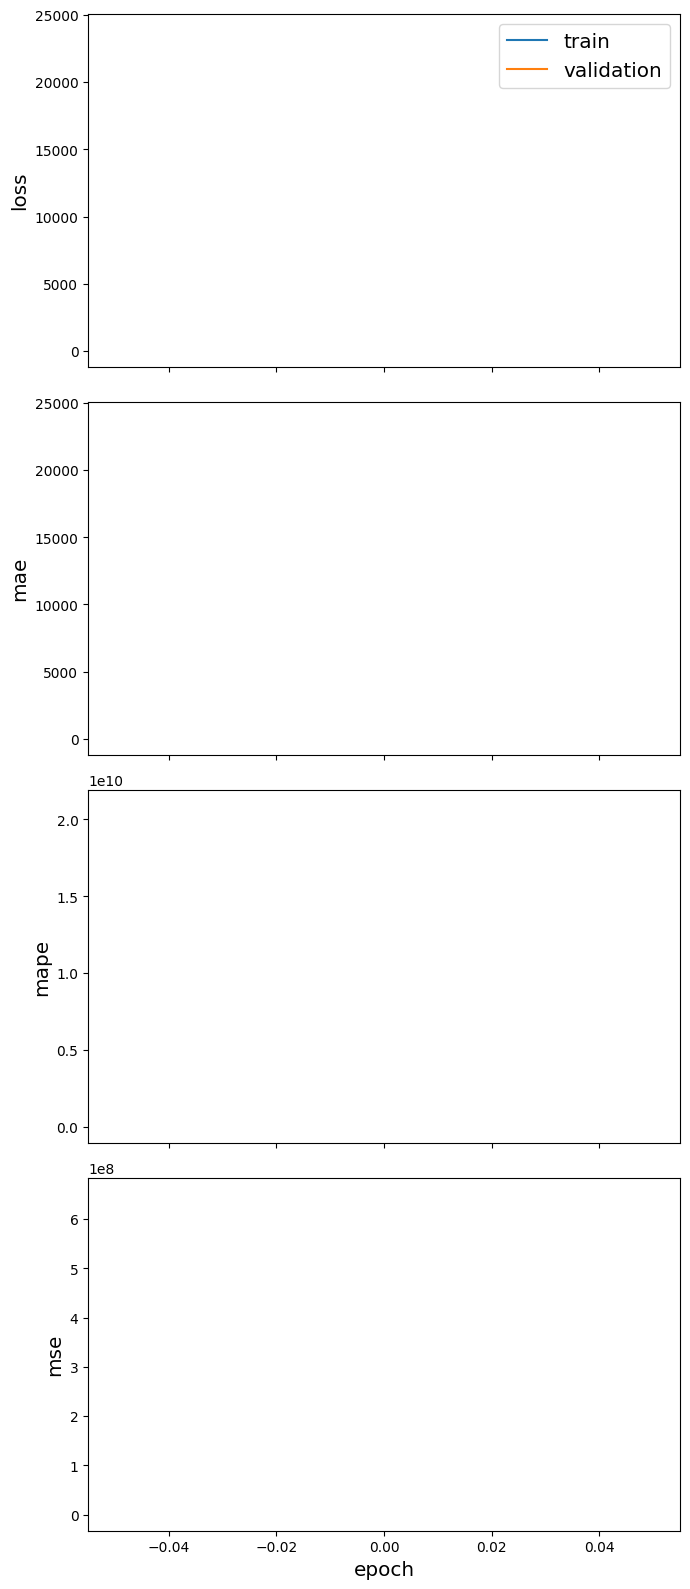

In [62]:
sg.utils.plot_history(history)

In [63]:
#val_subjects, 
#test_subjects

In [64]:
#test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 44ms/step - loss: 23867.7715 - mse: 651439232.0000 - mape: 2386777.2500 - mae: 23867.7715

Test Set Metrics:
	loss: 23867.7715
	mse: 651439232.0000
	mape: 2386777.2500
	mae: 23867.7715


In [65]:
#test_gen = generator.flow(test_subjects.index, test_targets)
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 45ms/step - loss: 51657.2305 - mse: 3078792960.0000 - mape: 51657236807680.0000 - mae: 51657.2305

Test Set Metrics:
	loss: 51657.2305
	mse: 3078792960.0000
	mape: 51657236807680.0000
	mae: 51657.2305


In [66]:
validation_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 44ms/step - loss: 12849.8447 - mse: 191436336.0000 - mape: 642492.2500 - mae: 12849.8447

Test Set Metrics:
	loss: 12849.8447
	mse: 191436336.0000
	mape: 642492.2500
	mae: 12849.8447


In [67]:
df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Pearson');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[1] = temp
df_metrics

['GCN-Pearson', 23867.771484375, 651439232.0, 2386777.25, 23867.771484375]


,Method,Loss,MSE,MAPE,MAE
1,GCN-Pearson,23867.771484,651439232.0,2386777.25,23867.771484


# Show the predicted prices by the Model

At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
I am just displaying the output. 
It appears that price is predicted for each timestamp (day)

In [68]:
#all_nodes = pearson_graph_node_data.index;
#all_gen = generator.flow(all_nodes)
#all_predictions = model.predict(test_gen)
test_predictions = model.predict(test_gen)

#all_nodes, 
#all_predictions, 
#all_predictions.shape, 
#pearson_graph_node_data.shape


#vars(train_gen)
#train_subjects.T['GM']

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
pearson_graph_node_data_test.index,  vars(test_gen),        test_predictions

1/1 [==============================] - 0s 330ms/step
10558.075
17684.082
27973.78
28552.023
24739.873
16122.859
-29280.926
-46740.773
15086.198
-35776.28
22498.168
18923.652
-18747.252
-21468.871


(Index(['JPM', 'KR', 'MCK', 'MSFT', 'PCAR', 'PSX', 'T', 'UNH'], dtype='object'),
 {'name': None,
  'graphs': array([<stellargraph.core.graph.StellarGraph object at 0x000002B2C9D79610>,
        dtype=object),
  'selected_ilocs': array([[1]]),
  'normalize_adj': True,
  'targets': array([1]),
  'batch_size': 1,
  'normalized_adjs': array([<14x14 sparse matrix of type '<class 'numpy.float64'>'
         	with 78 stored elements in Compressed Sparse Row format>,
         <8x8 sparse matrix of type '<class 'numpy.float64'>'
         	with 36 stored elements in Compressed Sparse Row format>,
         <6x6 sparse matrix of type '<class 'numpy.float64'>'
         	with 18 stored elements in Compressed Sparse Row format>],
        dtype=object),
  '_np_rs': <module 'numpy.random' from 'C:\\Users\\sayed\\.conda\\envs\\stellargraph\\lib\\site-packages\\numpy\\random\\__init__.py'>,
  'shuffle': False},
 array([[ 10558.075,  17684.082,  27973.78 ,  28552.023,  24739.873,
          16122.859, -29280

In [69]:
train_predictions = model.predict(train_gen)

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
train_predictions

1/1 [==============================] - 0s 37ms/step
10558.075
17684.082
27973.78
28552.023
24739.873
16122.859
-29280.926
-46740.773
15086.198
-35776.28
22498.168
18923.652
-18747.252
-21468.871


array([[ 21136.865,  43111.14 ,  67766.79 ,  73266.586,  66877.81 ,
         26312.795, -69706.56 , -93361.805,  27884.135, -61318.68 ,
         51232.332,  44197.383, -41220.18 , -35808.207]], dtype=float32)

In [70]:
test_predictions

array([[ 10558.075,  17684.082,  27973.78 ,  28552.023,  24739.873,
         16122.859, -29280.926, -46740.773,  15086.198, -35776.28 ,
         22498.168,  18923.652, -18747.252, -21468.871]], dtype=float32)

In [71]:
# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, pearson_graph_node_data.shape
# vars(all_gen)

In [72]:
pearson_graph_node_data

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


****************************************************
STOP because we are testing a new model
****************************************************

# SPEARMAN ***************************************************************************

An exception occurred. Operation ignored
(753, 29)
StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 260

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [260]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 68

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [68]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 8, Edges: 30

 Node types:
  corner: [8]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [30]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 10

 Node types:
  corner: [6]
    Features: float32 vector, length 753
    Edge types: corner-line->co

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


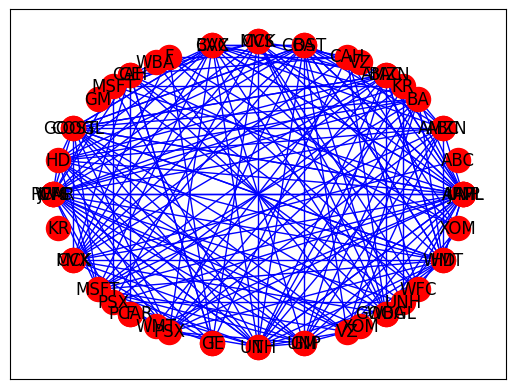

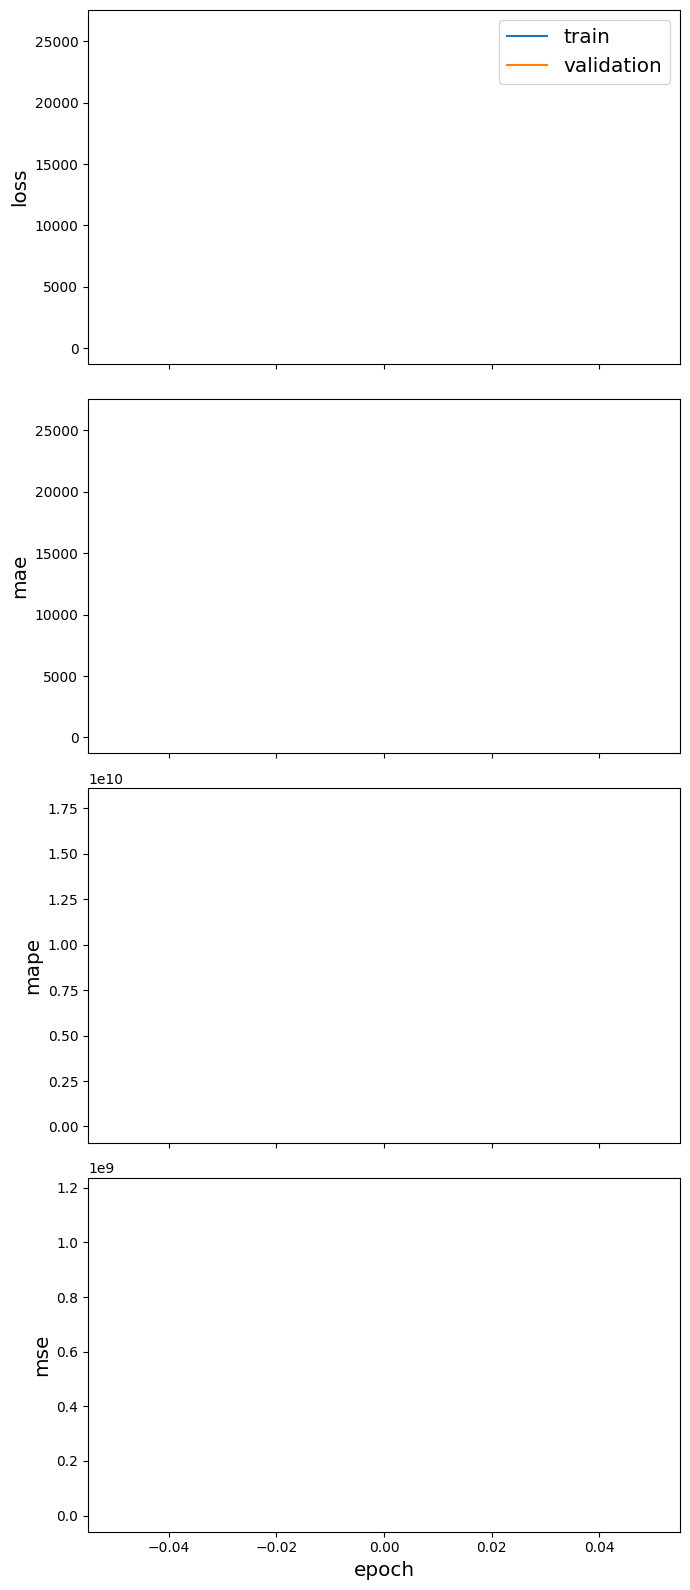

In [73]:
#!/usr/bin/env python
# coding: utf-8

# # 3rd Model: Deepgraph CNN: Stock Price Prediction using DeepGraphCNN Neural Networks. It includes GCN layers and CNN layers. I have added an MLP at the last layer to predict stock prices.
# 
# # Input graphs were created for Spearman, Spearman, and Kendal Tau correlations/coefficients from historical stock prices. Also, another graph is created based on financial news articles.
# 
# # For the sake of making execution easier (and at once), I have kept multiple approaches (Spearman, Spearman, and Kendal Tau, News Based) in the same file. One big code file can be difficult to handle; is done just for making execution easier.
# 
# # Because I initially tried separately and brought the code together, some code might be a bit redundant/repeating. I may have done some cleaning.
# 
# # An use case of DeepGraphCNN for Node Classification
# # https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html
# 

# # Import Libraries

# In[1]:


# import libraries
import os
import pandas as pd
import math


# In[2]:


# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN


# In[3]:


# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras


# In[4]:


# If we want to drop NAN column or row wise for stock price data
# I did not need to use this options that much
drop_cols_with_na = 1
drop_rows_with_na = 1


# # Dataset: Using 30 companies from the Fortune 500 companies (the paper used these stocks)

# In[5]:


df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()


# In[6]:


# You can see ANTM stock price data is empty


# # Cure data such as replace missing/null values, use correct data type, sort by date (not really required)

# In[7]:


# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted when I generated data
# df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()


# In[8]:


# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit

# check if any value is null    
df_s_transpose.isnull().values.any()

# check if any column (axis=1) is null
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    


# In[9]:


df_s_transpose


# In[10]:


# df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
print(df_s_transpose.shape)
df_s_transpose.head() 


# In[11]:


# further check and verify
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]


# In[12]:


# making the date column as the index column for the dataset
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')


# # Spearman Correlation Coefficient

# In[13]:


df_s_transpose_spearman = df_s_transpose.corr(method = 'spearman', numeric_only = True)
df_s_transpose_spearman


# # Spearman Correlation Coefficient based Adjacency Graph Matrix

# In[14]:


df_s_transpose_spearman[df_s_transpose_spearman >= 0.5] = 1
df_s_transpose_spearman[df_s_transpose_spearman < 0.5] = 0
df_s_transpose_spearman


# In[15]:


# make the diagonal element to be zero. No self loop/edge
import numpy as np
np.fill_diagonal(df_s_transpose_spearman.values, 0)
df_s_transpose_spearman


# In[16]:


# STOP


# Create and visualize the Graphs

# In[17]:


import networkx as nx
Graph_spearman = nx.Graph(df_s_transpose_spearman)


# In[18]:


nx.draw_networkx(Graph_spearman, pos = nx.circular_layout( Graph_spearman ), node_color = 'r', edge_color = 'b')


# # Experiment, we will divide the data into train, test, and validation graphs

# In[19]:


df_s_transpose.corr(method = 'spearman', numeric_only = True)
#df_s_transpose[[{1,2,3}]]
#df_s_transpose.iloc[:, 0:10]


# In[20]:


# Train Graph


# In[21]:


df_s_spearman_train = df_s_transpose.iloc[:, 0:15]
df_s_transpose_spearman_train = df_s_spearman_train.corr(method = 'spearman', numeric_only = True)
np.fill_diagonal(df_s_transpose_spearman_train.values, 0)

df_s_transpose_spearman_train[df_s_transpose_spearman_train >= 0.5] = 1
df_s_transpose_spearman_train[df_s_transpose_spearman_train < 0.5] = 0
df_s_transpose_spearman_train

df_s_transpose_spearman_train


# # Test Graph

# In[22]:


df_s_spearman_test = df_s_transpose.iloc[:, 15:23]
df_s_transpose_spearman_test = df_s_spearman_test.corr(method = 'spearman', numeric_only = True)
np.fill_diagonal(df_s_transpose_spearman_test.values, 0)

df_s_transpose_spearman_train[df_s_transpose_spearman_test >= 0.5] = 1
df_s_transpose_spearman_train[df_s_transpose_spearman_test < 0.5] = 0
df_s_transpose_spearman_test


# # Validation Graph

# In[23]:


df_s_spearman_validation = df_s_transpose.iloc[:, 23:]
df_s_transpose_spearman_validation = df_s_spearman_validation.corr(method = 'spearman', numeric_only = True)
np.fill_diagonal(df_s_transpose_spearman_validation.values, 0)
df_s_transpose_spearman_validation

df_s_transpose_spearman_validation[df_s_transpose_spearman_validation >= 0.5] = 1
df_s_transpose_spearman_validation[df_s_transpose_spearman_validation < 0.5] = 0
df_s_transpose_spearman_validation


# In[24]:


graph_spearman_train = nx.Graph(df_s_transpose_spearman_train)
graph_spearman_test = nx.Graph(df_s_transpose_spearman_test)
graph_spearman_validation = nx.Graph(df_s_transpose_spearman_validation)


nx.draw_networkx(graph_spearman_train, pos = nx.circular_layout( graph_spearman_train ), node_color = 'r', edge_color = 'b')


# In[25]:


df_s_spearman_train.corr(numeric_only = True)


# In[26]:


nx.draw_networkx(graph_spearman_test, pos = nx.circular_layout( graph_spearman_test ), node_color = 'r', edge_color = 'b')


# In[27]:


nx.draw_networkx(graph_spearman_validation, pos = nx.circular_layout( graph_spearman_validation ), node_color = 'r', edge_color = 'b')


# # Create GCN layer. Spearman

# # Find all stocks = nodes

# In[28]:


# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_spearman.index.to_list()
all_stock_nodes[:5]


# # Find all edges between nodes
# 
# This may need adjustment to reflect train, test, validation graphs

# In[29]:


source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_spearman[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)

# edge feature is not required except for news based graph
source, target, edge_feature            


# # Find all edges in Train, Test, and Validation Graphs

# In[30]:


trainSource = [];
trainTarget = [];
trainEdge_feature = [];
trainNodeList = df_s_transpose_spearman_train.index.to_list();

testSource = [];
testTarget = [];
testEdge_feature = [];
testNodeList = df_s_transpose_spearman_test.index.to_list();


validationSource = [];
validationTarget = [];
validationEdge_feature = [];
validationNodeList = df_s_transpose_spearman_validation.index.to_list();

for aStock in trainNodeList:
    for anotherStock in trainNodeList:        
        if df_s_transpose_spearman_train[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            trainSource.append(aStock)
            trainTarget.append(anotherStock)
            trainEdge_feature.append(1)
                
                
for aStock in testNodeList:
    for anotherStock in testNodeList:
        if df_s_transpose_spearman_test[aStock][anotherStock] > 0:
            #print(df_s_transpose_spearman[aStock][anotherStock])
            testSource.append(aStock)
            testTarget.append(anotherStock)
            testEdge_feature.append(1)

for aStock in validationNodeList:
    for anotherStock in validationNodeList:
        if df_s_transpose_spearman_validation[aStock][anotherStock] > 0:
            # print(df_s_transpose_spearman[aStock][anotherStock])
            validationSource.append(aStock)
            validationTarget.append(anotherStock)
            validationEdge_feature.append(1)
                        
# edge feature is not required except for news based graph
trainSource, trainTarget, trainEdge_feature
testSource, testTarget, testEdge_feature
validationSource, validationTarget, validationEdge_feature


# # Create variables to create stellar graph
# # Edges

# In[31]:


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
spearman_edges = pd.DataFrame(
    {"source": source, "target": target}
)

spearman_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
spearman_edges_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget}
)

spearman_edges_data_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget, "edge_feature": trainEdge_feature}
)

spearman_edges_test = pd.DataFrame(
    {"source": testSource, "target": testTarget}
)

spearman_edges_data_test = pd.DataFrame(
    {"source": testSource, "target": testTarget, "edge_feature": testEdge_feature}
)


spearman_edges_validation = pd.DataFrame(
    {"source": validationSource, "target": validationTarget}
)


spearman_edges_train[:10]


# # Have the time series data as part of the nodes

# # Structure the Feature Matrix so that it can be passed to the GCN

# In[32]:


df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].shape, df_s_transpose_feature['AAPL'].values


# In[33]:


len(all_stock_nodes)


# In[34]:


# bring/assign data to nodes
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    


# In[35]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
spearman_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
spearman_graph_node_data.head()


# In[36]:


node_Data[14:15], 
len(validationNodeList)
len(testNodeList)


# In[37]:


# Node time series data based on train, test, validation graph


# In[38]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
spearman_graph_node_data_train = pd.DataFrame(node_Data[0:14], index = trainNodeList)
spearman_graph_node_data_train.head()

spearman_graph_node_data_test = pd.DataFrame(node_Data[15:23], index = testNodeList)
spearman_graph_node_data_test.head()

spearman_graph_node_data_validation = pd.DataFrame(node_Data[22:30], index = validationNodeList)
spearman_graph_node_data_validation.head()



# In[39]:


spearman_graph_node_data_train


# # Graph (stellar) with features as part of Nodes

# In[40]:


# Overall
spearman_graph_with_node_features = StellarGraph(spearman_graph_node_data, edges = spearman_edges, node_type_default = "corner", edge_type_default = "line")
print(spearman_graph_with_node_features.info())

# train nodes
spearman_train_graph_with_node_features = StellarGraph(spearman_graph_node_data_train, edges = spearman_edges_train, node_type_default = "corner", edge_type_default = "line")
print(spearman_train_graph_with_node_features.info())

# test
spearman_test_graph_with_node_features = StellarGraph(spearman_graph_node_data_test, edges = spearman_edges_test, node_type_default = "corner", edge_type_default = "line")
print(spearman_test_graph_with_node_features.info())

# validation
spearman_validation_graph_with_node_features = StellarGraph(spearman_graph_node_data_validation, edges = spearman_edges_validation, node_type_default = "corner", edge_type_default = "line")
print(spearman_validation_graph_with_node_features.info())


# # Adapting everything for DeepGraphCNN

# In[41]:


spearman_graph_node_data.iloc[0:15, :]


# # Graphs to be jused for DeepGraphCNN

# In[42]:


graphs = list()
#graphs.append(spearman_graph_with_node_features)
graphs.append(spearman_train_graph_with_node_features)
graphs.append(spearman_test_graph_with_node_features)
graphs.append(spearman_validation_graph_with_node_features)


# In[43]:


summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round()


# In[44]:


# graph_labels = all_stock_nodes


# In[45]:


# Generator
#generator = FullBatchNodeGenerator(spearman_graph_with_node_features, method = "gcn") # , sparse = False
#vars(generator)

generator = PaddedGraphGenerator( graphs = graphs)
# generator = PaddedGraphGenerator( spearman_graph_with_node_features)


# In[46]:


vars(generator)


# # Train Test Split

# # Commented out on 2023-04-18
# train_subjects, test_subjects = model_selection.train_test_split(
#     spearman_graph_node_data 
# )
# 
# val_subjects, test_subjects_step_2 = model_selection.train_test_split(
#     test_subjects 
# )
# 
# #, train_size = 500, test_size = None, stratify = test_subjects
# 
# train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

# In[47]:


train_subjects = spearman_graph_node_data_train;
test_subjects = spearman_graph_node_data_test;
val_subjects = spearman_graph_node_data_validation;


# In[48]:


train_subjects


# In[49]:


# Commented out on 2023-04-18
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 


# # The Model for all of the approaches utilized in this file
# # Model for Spearman, Spearman, Kendal Tau, Financial News Based prediction

# # Models : DeepGraph CNN

# In[50]:


#epochs_to_test = 1000
#patience_to_test = 1000


# In[51]:


# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


unit_count = 14
k = unit_count # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes = layer_sizes,
    # activations = ["tanh", "tanh", "tanh", "tanh"],
    activations = ["relu", "relu", "relu", "relu"],
    k = k,
    bias = False,
    generator = generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#print(graphs[0].info())
x_inp, x_out


# In[52]:


# dgcnn_model.summary()

# print(dgcnn_model.info())
dgcnn_model    


# In[53]:


train_targets.index


# In[54]:


x_out = Conv1D(filters = 16, kernel_size = sum(layer_sizes), strides = sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters = 32, kernel_size = 5, strides = 1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units = 128, activation = "relu")(x_out)
x_out = Dropout(rate = 0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
predictions = layers.Dense(units = len(train_targets), activation = "linear")(x_out)
#predictions = layers.Dense(units = 1, activation = "linear")(x_out)


# In[55]:


# Commented out on 2023-04-18

model = Model(inputs = x_inp, outputs = predictions)

model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( learning_rate = 0.1), 
    metrics = ['mse', 'mape', 'mae']
)


# # Commented out on 2023-04-18
# 
# # hard coded size adjustments
# #test_subjects_ = test_subjects[:len(val_subjects)]
# 
# #val_gen = generator.flow(val_subjects.index, test_subjects_)
# #train_gen[1], val_gen[1]
# #val_gen[4]

# #  Multiple Graph Version Starts

# In[56]:


# Worked
train_gen = generator.flow(
    #list(train_subjects.index),
    #train_gen_node_id_list,
    [0],
    targets = [0], #train_subjects.values,
    batch_size = 1,
    symmetric_normalization = False,
)

test_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [1],
    targets = [1],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

val_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets = [2],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

'''
all_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets=2,#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)
'''
#data_valid = val_gen #[:1][:4];
#train_gen_data = train_gen #[:1][:4];


# In[57]:


vars(train_gen)
#train_subjects
#train_subjects.values


# In[58]:


vars(train_gen), 
#train_subjects
#train_subjects.values


# In[59]:


train_subjects, test_gen


# In[60]:


#train_gen, data_valid, train_gen_data


# In[61]:


# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn
# with DeepGraphCNN model.fit
history = model.fit(
    train_gen, epochs = epochs_to_test, verbose = 1, validation_data = test_gen, shuffle = False,
)


# In[62]:


sg.utils.plot_history(history)


# In[63]:


#val_subjects, 
#test_subjects


# In[64]:


#test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[65]:


#test_gen = generator.flow(test_subjects.index, test_targets)
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[66]:


validation_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[67]:


#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Spearman');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[2] = temp
df_metrics


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[68]:


#all_nodes = spearman_graph_node_data.index;
#all_gen = generator.flow(all_nodes)
#all_predictions = model.predict(test_gen)
test_predictions = model.predict(test_gen)

#all_nodes, 
#all_predictions, 
#all_predictions.shape, 
#spearman_graph_node_data.shape


#vars(train_gen)
#train_subjects.T['GM']

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
spearman_graph_node_data_test.index,  vars(test_gen),        test_predictions


# In[69]:


train_predictions = model.predict(train_gen)

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
train_predictions


# In[70]:


test_predictions


# In[72]:


# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, spearman_graph_node_data.shape
# vars(all_gen)


# In[73]:


spearman_graph_node_data


# In[ ]:


# Kendal Tau

An exception occurred. Operation ignored
(753, 29)
StellarGraph: Undirected multigraph
 Nodes: 28, Edges: 152

 Node types:
  corner: [28]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [152]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 14, Edges: 42

 Node types:
  corner: [14]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [42]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 8, Edges: 32

 Node types:
  corner: [8]
    Features: float32 vector, length 753
    Edge types: corner-line->corner

 Edge types:
    corner-line->corner: [32]
        Weights: all 1 (default)
        Features: none
StellarGraph: Undirected multigraph
 Nodes: 6, Edges: 6

 Node types:
  corner: [6]
    Features: float32 vector, length 753
    Edge types: corner-line->cor

,0,1,2,3,4,5,6,7,8,9,...,743,744,745,746,747,748,749,750,751,752
AAPL,29.037500,29.004999,29.152500,29.477501,29.747499,29.777500,29.937500,29.812500,29.760000,30.000000,...,69.964996,70.102501,69.934998,70.004997,69.860001,71.000000,71.067497,72.477501,72.449997,72.879997
ABC,82.610001,84.660004,83.680000,84.800003,85.480003,84.830002,81.529999,83.860001,84.620003,85.989998,...,85.959999,83.150002,83.550003,83.800003,85.669998,85.599998,85.419998,85.050003,84.910004,83.639999
AMZN,37.683498,37.859001,39.022499,39.799500,39.846001,39.794998,39.951000,40.681999,40.856998,40.486000,...,88.460503,89.532997,89.201500,89.613998,89.324997,89.650002,89.460503,93.438499,93.489998,92.344498
BA,156.970001,158.619995,158.710007,159.100006,158.320007,159.070007,159.399994,158.289993,158.830002,157.669998,...,327.000000,327.000000,330.679993,333.500000,328.000000,337.549988,333.000000,329.920013,330.140015,326.399994
BAC,22.530001,22.950001,22.680000,22.680000,22.549999,22.940001,23.070000,22.920000,23.010000,22.049999,...,34.700001,35.040001,35.110001,34.950001,34.959999,35.169998,35.220001,35.520000,35.349998,35.150002
CAH,74.480003,75.629997,74.500000,75.330002,74.760002,75.220001,73.720001,74.190002,75.000000,75.180000,...,53.700001,51.570000,51.099998,50.610001,51.799999,51.130001,51.290001,51.169998,51.500000,50.770000
COST,159.729996,159.759995,162.910004,162.830002,160.970001,161.660004,161.539993,161.869995,161.860001,163.809998,...,293.500000,295.549988,291.869995,293.709991,294.829987,293.309998,294.230011,295.730011,294.109985,295.140015
CVS,80.349998,79.750000,81.419998,82.199997,81.699997,82.669998,82.769997,82.599998,81.980003,83.919998,...,74.400002,73.349998,73.279999,74.099998,74.580002,74.379997,74.510002,74.480003,74.400002,73.699997
CVX,117.849998,117.820000,117.309998,116.839996,115.839996,114.959999,115.930000,116.160004,116.379997,116.279999,...,119.360001,118.599998,118.550003,118.129997,119.680000,120.330002,120.339996,120.599998,120.300003,119.849998
F,12.590000,13.170000,12.770000,12.760000,12.630000,12.850000,12.670000,12.590000,12.630000,12.610000,...,9.390000,9.390000,9.540000,9.410000,9.480000,9.440000,9.470000,9.450000,9.360000,9.250000


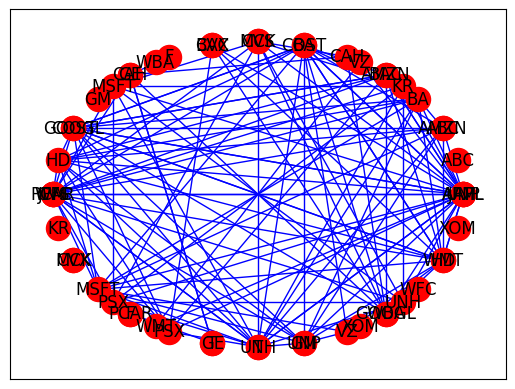

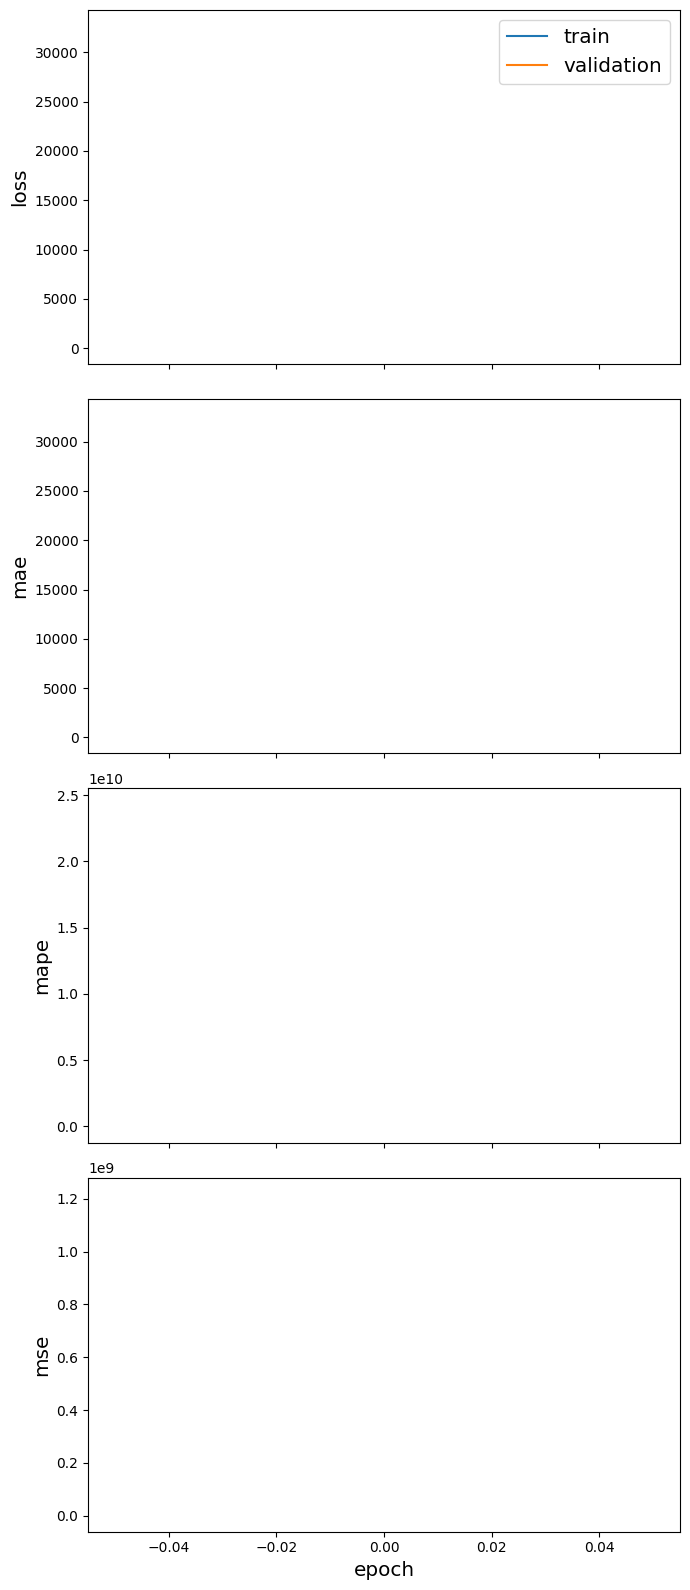

In [74]:
#!/usr/bin/env python
# coding: utf-8

# # 3rd Model: Deepgraph CNN: Stock Price Prediction using DeepGraphCNN Neural Networks. It includes GCN layers and CNN layers. I have added an MLP at the last layer to predict stock prices.
# 
# # Input graphs were created for Kendall, Spearman, and Kendal Tau correlations/coefficients from historical stock prices. Also, another graph is created based on financial news articles.
# 
# # For the sake of making execution easier (and at once), I have kept multiple approaches (Kendall, Spearman, and Kendal Tau, News Based) in the same file. One big code file can be difficult to handle; is done just for making execution easier.
# 
# # Because I initially tried separately and brought the code together, some code might be a bit redundant/repeating. I may have done some cleaning.
# 
# # An use case of DeepGraphCNN for Node Classification
# # https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html
# 

# # Import Libraries

# In[1]:


# import libraries
import os
import pandas as pd
import math


# In[2]:


# Import Libraries for Graph, GNN, and GCN
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCN


# In[3]:


# Machine Learnig related library Imports
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow import keras


# In[4]:


# If we want to drop NAN column or row wise for stock price data
# I did not need to use this options that much
drop_cols_with_na = 1
drop_rows_with_na = 1


# # Dataset: Using 30 companies from the Fortune 500 companies (the paper used these stocks)

# In[5]:


df_s = pd.DataFrame();
data_file = "per-day-fortune-30-company-stock-price-data.csv";
df_s = pd.read_csv("./data/" + data_file, low_memory = False);
df_s.head()


# In[6]:


# You can see ANTM stock price data is empty


# # Cure data such as replace missing/null values, use correct data type, sort by date (not really required)

# In[7]:


# convert Date field to be a Date Type
df_s["Date"] = df_s["Date"].astype('datetime64[ns]')

# Sort data by date although this is no longer needed as data already is sorted when I generated data
# df_s = df_s.sort_values( by = ['Ticker','Date'], ascending = True )
df_s = df_s.sort_values( by = 'Date', ascending = True )
df_s.head()


# In[8]:


# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
df_s_transpose = df_s

try:
  df_s_transpose = df_s_transpose.interpolate(inplace = False)
except:
  print("An exception occurred. Operation ignored")
  exit

# check if any value is null    
df_s_transpose.isnull().values.any()

# check if any column (axis=1) is null
df_s_transpose[df_s_transpose.isna().any(axis = 1)]    


# In[9]:


df_s_transpose


# In[10]:


# df_s_transpose = df_s

if drop_cols_with_na == 1:
    df_s_transpose = df_s_transpose.dropna(axis = 1);    
   
print(df_s_transpose.shape)
df_s_transpose.head() 


# In[11]:


# further check and verify
df_s_transpose.isnull().values.any()
df_s_transpose[df_s_transpose.isna().any( axis = 1 )]


# In[12]:


# making the date column as the index column for the dataset
# df_s_transpose.index = df_s_transpose['Date']
df_s_transpose.index = df_s_transpose.index.astype('datetime64[ns]')


# # Kendall Correlation Coefficient

# In[13]:


df_s_transpose_kendall = df_s_transpose.corr(method = 'kendall', numeric_only = True)
df_s_transpose_kendall


# # Kendall Correlation Coefficient based Adjacency Graph Matrix

# In[14]:


df_s_transpose_kendall[df_s_transpose_kendall >= 0.5] = 1
df_s_transpose_kendall[df_s_transpose_kendall < 0.5] = 0
df_s_transpose_kendall


# In[15]:


# make the diagonal element to be zero. No self loop/edge
import numpy as np
np.fill_diagonal(df_s_transpose_kendall.values, 0)
df_s_transpose_kendall


# In[16]:


# STOP


# Create and visualize the Graphs

# In[17]:


import networkx as nx
Graph_kendall = nx.Graph(df_s_transpose_kendall)


# In[18]:


nx.draw_networkx(Graph_kendall, pos = nx.circular_layout( Graph_kendall ), node_color = 'r', edge_color = 'b')


# # Experiment, we will divide the data into train, test, and validation graphs

# In[19]:


df_s_transpose.corr(method = 'kendall', numeric_only = True)
#df_s_transpose[[{1,2,3}]]
#df_s_transpose.iloc[:, 0:10]


# In[20]:


# Train Graph


# In[21]:


df_s_kendall_train = df_s_transpose.iloc[:, 0:15]
df_s_transpose_kendall_train = df_s_kendall_train.corr(method = 'kendall', numeric_only = True)
np.fill_diagonal(df_s_transpose_kendall_train.values, 0)

df_s_transpose_kendall_train[df_s_transpose_kendall_train >= 0.5] = 1
df_s_transpose_kendall_train[df_s_transpose_kendall_train < 0.5] = 0
df_s_transpose_kendall_train

df_s_transpose_kendall_train


# # Test Graph

# In[22]:


df_s_kendall_test = df_s_transpose.iloc[:, 15:23]
df_s_transpose_kendall_test = df_s_kendall_test.corr(method = 'kendall', numeric_only = True)
np.fill_diagonal(df_s_transpose_kendall_test.values, 0)

df_s_transpose_kendall_train[df_s_transpose_kendall_test >= 0.5] = 1
df_s_transpose_kendall_train[df_s_transpose_kendall_test < 0.5] = 0
df_s_transpose_kendall_test


# # Validation Graph

# In[23]:


df_s_kendall_validation = df_s_transpose.iloc[:, 23:]
df_s_transpose_kendall_validation = df_s_kendall_validation.corr(method = 'kendall', numeric_only = True)
np.fill_diagonal(df_s_transpose_kendall_validation.values, 0)
df_s_transpose_kendall_validation

df_s_transpose_kendall_validation[df_s_transpose_kendall_validation >= 0.5] = 1
df_s_transpose_kendall_validation[df_s_transpose_kendall_validation < 0.5] = 0
df_s_transpose_kendall_validation


# In[24]:


graph_kendall_train = nx.Graph(df_s_transpose_kendall_train)
graph_kendall_test = nx.Graph(df_s_transpose_kendall_test)
graph_kendall_validation = nx.Graph(df_s_transpose_kendall_validation)


nx.draw_networkx(graph_kendall_train, pos = nx.circular_layout( graph_kendall_train ), node_color = 'r', edge_color = 'b')


# In[25]:


df_s_kendall_train.corr(numeric_only = True)


# In[26]:


nx.draw_networkx(graph_kendall_test, pos = nx.circular_layout( graph_kendall_test ), node_color = 'r', edge_color = 'b')


# In[27]:


nx.draw_networkx(graph_kendall_validation, pos = nx.circular_layout( graph_kendall_validation ), node_color = 'r', edge_color = 'b')


# # Create GCN layer. Kendall

# # Find all stocks = nodes

# In[28]:


# improvement: make sure only stocks/nodes that are in the graph are taken
all_stock_nodes = df_s_transpose_kendall.index.to_list()
all_stock_nodes[:5]


# # Find all edges between nodes
# 
# This may need adjustment to reflect train, test, validation graphs

# In[29]:


source = [];
target = [];
edge_feature = [];

for aStock in all_stock_nodes:
    for anotherStock in all_stock_nodes:
        if df_s_transpose_kendall[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            source.append(aStock)
            target.append(anotherStock)
            edge_feature.append(1)

# edge feature is not required except for news based graph
source, target, edge_feature            


# # Find all edges in Train, Test, and Validation Graphs

# In[30]:


trainSource = [];
trainTarget = [];
trainEdge_feature = [];
trainNodeList = df_s_transpose_kendall_train.index.to_list();

testSource = [];
testTarget = [];
testEdge_feature = [];
testNodeList = df_s_transpose_kendall_test.index.to_list();


validationSource = [];
validationTarget = [];
validationEdge_feature = [];
validationNodeList = df_s_transpose_kendall_validation.index.to_list();

for aStock in trainNodeList:
    for anotherStock in trainNodeList:        
        if df_s_transpose_kendall_train[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            trainSource.append(aStock)
            trainTarget.append(anotherStock)
            trainEdge_feature.append(1)
                
                
for aStock in testNodeList:
    for anotherStock in testNodeList:
        if df_s_transpose_kendall_test[aStock][anotherStock] > 0:
            #print(df_s_transpose_kendall[aStock][anotherStock])
            testSource.append(aStock)
            testTarget.append(anotherStock)
            testEdge_feature.append(1)

for aStock in validationNodeList:
    for anotherStock in validationNodeList:
        if df_s_transpose_kendall_validation[aStock][anotherStock] > 0:
            # print(df_s_transpose_kendall[aStock][anotherStock])
            validationSource.append(aStock)
            validationTarget.append(anotherStock)
            validationEdge_feature.append(1)
                        
# edge feature is not required except for news based graph
trainSource, trainTarget, trainEdge_feature
testSource, testTarget, testEdge_feature
validationSource, validationTarget, validationEdge_feature


# # Create variables to create stellar graph
# # Edges

# In[31]:


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
kendall_edges = pd.DataFrame(
    {"source": source, "target": target}
)

kendall_edges_data = pd.DataFrame(
    {"source": source, "target": target, "edge_feature": edge_feature}
)


# https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
kendall_edges_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget}
)

kendall_edges_data_train = pd.DataFrame(
    {"source": trainSource, "target": trainTarget, "edge_feature": trainEdge_feature}
)

kendall_edges_test = pd.DataFrame(
    {"source": testSource, "target": testTarget}
)

kendall_edges_data_test = pd.DataFrame(
    {"source": testSource, "target": testTarget, "edge_feature": testEdge_feature}
)


kendall_edges_validation = pd.DataFrame(
    {"source": validationSource, "target": validationTarget}
)


kendall_edges_train[:10]


# # Have the time series data as part of the nodes

# # Structure the Feature Matrix so that it can be passed to the GCN

# In[32]:


df_s_transpose_feature = df_s_transpose.reset_index(drop = True, inplace = False)
# df_s_transpose_feature =  df_s_transpose_feature.values.tolist()
# print(df_s_transpose_feature.values.tolist())
#df_s_transpose_feature['WY'].values
df_s_transpose_feature['AAPL'].shape, df_s_transpose_feature['AAPL'].values


# In[33]:


len(all_stock_nodes)


# In[34]:


# bring/assign data to nodes
node_Data = [];
for x in all_stock_nodes:
    node_Data.append( df_s_transpose_feature[x].values)
    
    
node_Data    


# In[35]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
kendall_graph_node_data = pd.DataFrame(node_Data, index = all_stock_nodes)
kendall_graph_node_data.head()


# In[36]:


node_Data[14:15], 
len(validationNodeList)
len(testNodeList)


# In[37]:


# Node time series data based on train, test, validation graph


# In[38]:


# convert node data variable into a dataframe so that the data structure is compatible with graph NN
kendall_graph_node_data_train = pd.DataFrame(node_Data[0:14], index = trainNodeList)
kendall_graph_node_data_train.head()

kendall_graph_node_data_test = pd.DataFrame(node_Data[15:23], index = testNodeList)
kendall_graph_node_data_test.head()

kendall_graph_node_data_validation = pd.DataFrame(node_Data[22:30], index = validationNodeList)
kendall_graph_node_data_validation.head()



# In[39]:


kendall_graph_node_data_train


# # Graph (stellar) with features as part of Nodes

# In[40]:


# Overall
kendall_graph_with_node_features = StellarGraph(kendall_graph_node_data, edges = kendall_edges, node_type_default = "corner", edge_type_default = "line")
print(kendall_graph_with_node_features.info())

# train nodes
kendall_train_graph_with_node_features = StellarGraph(kendall_graph_node_data_train, edges = kendall_edges_train, node_type_default = "corner", edge_type_default = "line")
print(kendall_train_graph_with_node_features.info())

# test
kendall_test_graph_with_node_features = StellarGraph(kendall_graph_node_data_test, edges = kendall_edges_test, node_type_default = "corner", edge_type_default = "line")
print(kendall_test_graph_with_node_features.info())

# validation
kendall_validation_graph_with_node_features = StellarGraph(kendall_graph_node_data_validation, edges = kendall_edges_validation, node_type_default = "corner", edge_type_default = "line")
print(kendall_validation_graph_with_node_features.info())


# # Adapting everything for DeepGraphCNN

# In[41]:


kendall_graph_node_data.iloc[0:15, :]


# # Graphs to be jused for DeepGraphCNN

# In[42]:


graphs = list()
#graphs.append(kendall_graph_with_node_features)
graphs.append(kendall_train_graph_with_node_features)
graphs.append(kendall_test_graph_with_node_features)
graphs.append(kendall_validation_graph_with_node_features)


# In[43]:


summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round()


# In[44]:


# graph_labels = all_stock_nodes


# In[45]:


# Generator
#generator = FullBatchNodeGenerator(kendall_graph_with_node_features, method = "gcn") # , sparse = False
#vars(generator)

generator = PaddedGraphGenerator( graphs = graphs)
# generator = PaddedGraphGenerator( kendall_graph_with_node_features)


# In[46]:


vars(generator)


# # Train Test Split

# # Commented out on 2023-04-18
# train_subjects, test_subjects = model_selection.train_test_split(
#     kendall_graph_node_data 
# )
# 
# val_subjects, test_subjects_step_2 = model_selection.train_test_split(
#     test_subjects 
# )
# 
# #, train_size = 500, test_size = None, stratify = test_subjects
# 
# train_subjects.shape, test_subjects.shape, val_subjects.shape, test_subjects_step_2.shape

# In[47]:


train_subjects = kendall_graph_node_data_train;
test_subjects = kendall_graph_node_data_test;
val_subjects = kendall_graph_node_data_validation;


# In[48]:


train_subjects


# In[49]:


# Commented out on 2023-04-18
train_targets = train_subjects; 
val_targets = val_subjects; 
test_targets = test_subjects; 


# # The Model for all of the approaches utilized in this file
# # Model for Kendall, Spearman, Kendal Tau, Financial News Based prediction

# # Models : DeepGraph CNN

# In[50]:


#epochs_to_test = 1000
#patience_to_test = 1000


# In[51]:


# Experiment with DeepGraphCNN
# https://stellargraph.readthedocs.io/en/latest/demos/graph-classification/dgcnn-graph-classification.html


unit_count = 14
k = unit_count # the number of rows for the output tensor
layer_sizes = [32, 32, 32, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes = layer_sizes,
    # activations = ["tanh", "tanh", "tanh", "tanh"],
    activations = ["relu", "relu", "relu", "relu"],
    k = k,
    bias = False,
    generator = generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

#print(graphs[0].info())
x_inp, x_out


# In[52]:


# dgcnn_model.summary()

# print(dgcnn_model.info())
dgcnn_model    


# In[53]:


train_targets.index


# In[54]:


x_out = Conv1D(filters = 16, kernel_size = sum(layer_sizes), strides = sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters = 32, kernel_size = 5, strides = 1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units = 128, activation = "relu")(x_out)
x_out = Dropout(rate = 0.5)(x_out)

#predictions = Dense(units=1, activation="linear")(x_out)
#predictions = layers.Dense(units = train_targets.shape[1], activation = "linear")(x_out)
predictions = layers.Dense(units = len(train_targets), activation = "linear")(x_out)
#predictions = layers.Dense(units = 1, activation = "linear")(x_out)


# In[55]:


# Commented out on 2023-04-18

model = Model(inputs = x_inp, outputs = predictions)

model.compile(
    loss = 'mean_absolute_error', 
    optimizer = optimizers.Adam( learning_rate = 0.1), 
    metrics = ['mse', 'mape', 'mae']
)


# # Commented out on 2023-04-18
# 
# # hard coded size adjustments
# #test_subjects_ = test_subjects[:len(val_subjects)]
# 
# #val_gen = generator.flow(val_subjects.index, test_subjects_)
# #train_gen[1], val_gen[1]
# #val_gen[4]

# #  Multiple Graph Version Starts

# In[56]:


# Worked
train_gen = generator.flow(
    #list(train_subjects.index),
    #train_gen_node_id_list,
    [0],
    targets = [0], #train_subjects.values,
    batch_size = 1,
    symmetric_normalization = False,
)

test_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [1],
    targets = [1],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

val_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets = [2],#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)

'''
all_gen = generator.flow(
    #list(test_targets.index),
    #test_gen_node_id_list,
    [2],
    targets=2,#test_targets.values,
    batch_size = 1,
    symmetric_normalization = False,
)
'''
#data_valid = val_gen #[:1][:4];
#train_gen_data = train_gen #[:1][:4];


# In[57]:


vars(train_gen)
#train_subjects
#train_subjects.values


# In[58]:


vars(train_gen), 
#train_subjects
#train_subjects.values


# In[59]:


train_subjects, test_gen


# In[60]:


#train_gen, data_valid, train_gen_data


# In[61]:


# https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn
# with DeepGraphCNN model.fit
history = model.fit(
    train_gen, epochs = epochs_to_test, verbose = 1, validation_data = test_gen, shuffle = False,
)


# In[62]:


sg.utils.plot_history(history)


# In[63]:


#val_subjects, 
#test_subjects


# In[64]:


#test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[65]:


#test_gen = generator.flow(test_subjects.index, test_targets)
train_metrics = model.evaluate(train_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[66]:


validation_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, validation_metrics):
    print("\t{}: {:0.4f}".format(name, val))


# In[67]:


#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Kendall');
for name, val in zip(model.metrics_names, test_metrics):
    # print(val)
    temp.append(val)

print(temp)
df_metrics.loc[3] = temp
df_metrics


# # Show the predicted prices by the Model
# 
# At this point, I still need to make sense of what GCN ( and CNN) combination + MLP is predicting. 
# I am just displaying the output. 
# It appears that price is predicted for each timestamp (day)

# In[68]:


#all_nodes = kendall_graph_node_data.index;
#all_gen = generator.flow(all_nodes)
#all_predictions = model.predict(test_gen)
test_predictions = model.predict(test_gen)

#all_nodes, 
#all_predictions, 
#all_predictions.shape, 
#kendall_graph_node_data.shape


#vars(train_gen)
#train_subjects.T['GM']

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
kendall_graph_node_data_test.index,  vars(test_gen),        test_predictions


# In[69]:


train_predictions = model.predict(train_gen)

for x in test_predictions:
    for y in x:
        print(y);
        #print(type(y))
        
train_predictions


# In[70]:


test_predictions


# In[72]:


# all_predictions = model.predict(all_nodes)

# all_predictions, all_predictions.shape, kendall_graph_node_data.shape
# vars(all_gen)


# In[73]:


kendall_graph_node_data


# In[ ]:


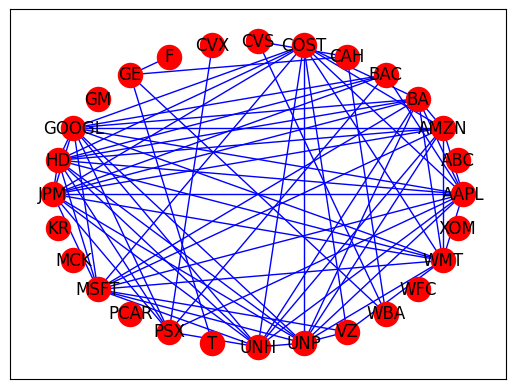

In [75]:
nx.draw_networkx(Graph_kendall, pos=nx.circular_layout(Graph_kendall), node_color='r', edge_color='b')

In [76]:
#df_metrics = pd.DataFrame(columns=['Method', 'Loss', 'MSE', 'MAPE', 'MAE'])

temp = list()
temp.append('GCN-Kendall');
for name, val in zip(model.metrics_names, test_metrics):    
    temp.append(val)

print(temp)
df_metrics.loc[3] = temp


['GCN-Kendall', 32659.76953125, 1219404416.0, 3265977.0, 32659.76953125]


In [77]:
# import math
df_metrics_plot = df_metrics[['Loss', 'MSE', 'MAPE', 'MAE']]

#temp = [10.71573, 13.578422, 10.71573, 16.638063]
#temp = [19.04899024963379, 1377.4075927734375, 19.04899024963379, 26.09033203125]
#df_metrics_plot.loc[4] = temp

df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']];
df_metrics_plot
#df_metrics, df_metrics_plot

C:\Users\sayed\AppData\Local\Temp\ipykernel_23860\2087146190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_plot['MSE'] = [ math.sqrt(x) for x in df_metrics_plot['MSE']];


,Loss,MSE,MAPE,MAE
1,23867.771484,25523.307623,2386777.25,23867.771484
2,26232.582031,34332.044507,2623258.25,26232.582031
3,32659.769531,34919.971592,3265977.00,32659.769531


<Axes: >

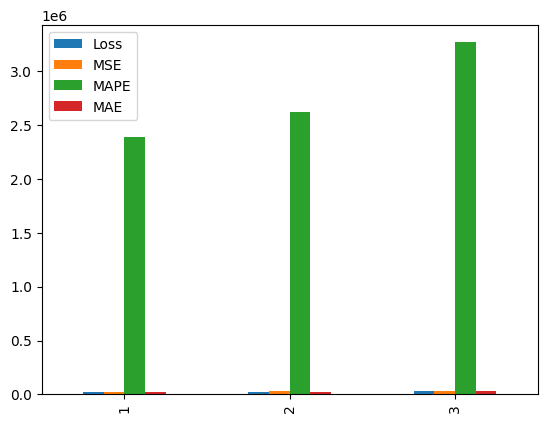

In [78]:
df_metrics_plot.plot( kind = 'bar')

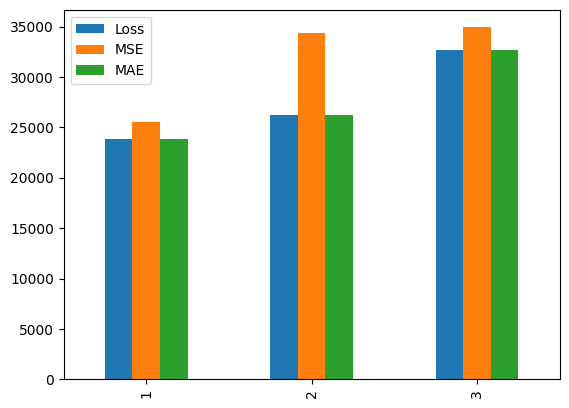

In [79]:
df_metrics_no_mape_plot = df_metrics_plot[['Loss', 'MSE', 'MAE']]
df_metrics_no_mape_plot.plot(kind='bar');

In [80]:
round(df_metrics_plot.T,1)

,1,2,3
Loss,23867.8,26232.6,32659.8
MSE,25523.3,34332.0,34920.0
MAPE,2386777.2,2623258.2,3265977.0
MAE,23867.8,26232.6,32659.8


# Because it can be tricky (not impossible) to implement for Financial News Based Graph -- for now -- I want to skip that

# For the sake of easier execution, I have brought financial news based prediction in the same code file

To start with, I have taken ideas from the following code esp. to see what GCN is and how GCN works.

Although, it does not use any CNN. 

Node classification with Graph Convolutional Network (GCN). 

https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 

References:



[1] Node classification with Graph Convolutional Network (GCN). https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html 


[2] Loading data into StellarGraph from Pandas. https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html

[3] Load Timeseries https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-numpy.html

[4] NetworkX: https://networkx.org/documentation/stable/reference/introduction.html 

[5]  StellerGraph and Networkx https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-networkx.html 

[6] Select StellerGraph Algorithm : https://stellargraph.readthedocs.io/en/stable/demos/#find-a-demo-for-an-algorithm 
[link text](https://)


Learning: 
GNN/GCN/Keras
https://www.youtube.com/watch?v=0KH95BEz370


Install StellarGraph:
https://pypi.org/project/stellargraph/#install-stellargraph-using-pypi


May want to use without Stellar
https://keras.io/examples/graph/gnn_citations/

to get feature data from pandas dataframe: 
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html


Create graph properly:
https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html    

https://stellargraph.readthedocs.io/en/v0.11.0/api.html


Graph Regression Dataset
https://paperswithcode.com/task/graph-regression/codeless

StellerGraph Reference:
https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html
https://stellargraph.readthedocs.io

GRaph CNN or similar
It has multiple GCN layers and one 1d CNN + ... this idea might help
https://stellargraph.readthedocs.io/en/stable/demos/graph-classification/dgcnn-graph-classification.html?highlight=cnn

# References -- exploring ideas on the GCN-CNN
https://ieeexplore.ieee.org/document/9149910

https://antonsruberts.github.io/graph/gcn/

This may work. As Unit GCN is created also unit tcn. This may give the opportunity to customize to product the correct output
https://github.com/lshiwjx/2s-AGCN  https://paperswithcode.com/paper/non-local-graph-convolutional-networks-for

    

# from scracth and equations
https://towardsdatascience.com/understanding-graph-convolutional-networks-for-node-classification-a2bfdb7aba7b

https://jonathan-hui.medium.com/graph-convolutional-networks-gcn-pooling-839184205692

In [81]:
# Time Series
# https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/
    

# Understand the output

In [82]:
# https://www.baeldung.com/cs/learning-curve-ml